# Homework 6

In this homework, you'll review some linear algebra, and practice using `sklearn` and `scipy.optimize` to solve several variations of linear models.  You'll also use Pandas and Scikit learn for a simple machine learning task on a UCI data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
import sklearn

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but we'll use Householder notation by replacing $\beta$ with `b`
```
y = X * b + eps
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features.  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  Our goal is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (30 points)

There are a variety of ways to solve the above problem.  We'll assume that $n > p$, meaning there are more observations than features.

### Generating Data

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well.


In [2]:
# Generate a linear least squares problem, return X, y and b, where b is the "ground truth" coefficient
def gen_lstsq(n, p, sig=0.1):
    """
    Generate a linear least squares problem:
    Size of X: n*p, n > p
    return: X, y and b
    """
    X = np.random.randn(n,p)
    b = np.random.randn(p)
    y = np.dot(X, b) + sig * np.random.randn(n)
    return X, y, b

### QR factorization

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above.

In [3]:
# Use QR factorization to find b_hat
def solve_lstsq_qr(X, y):
    Q, R = la.qr(X, mode='economic')
    b_hat = la.solve_triangular(R, Q.T @ y, lower=False)
    return b_hat

### Normal Equations

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above.  You probably don't want to form the inverse - use an LU or Cholesky factorization instead.

In [4]:
# Use Normal Equation to solve. Here we use Cholesky Factorization
def solve_lstsq_normal(X, y):
    """
    Goal: solve (X.T @ X) @ b = X.T @ y
    First step: perform Cholesky factorization on X.T @ X
    Then solve m = L.T @ b such that L @ m = X.T @ X
    Next solve b such that m = L.T @ b
    """
    L = np.linalg.cholesky(X.T @ X)
    m = la.solve_triangular(L, X.T @ y, lower=True)
    b = la.solve_triangular(L.T, m, lower=False)
    return b

### Check Your Work

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

In [5]:
# First we generate the problem
X, y, b = gen_lstsq(500, 300, sig=0.1)
# Then we solve and compare
b_hat_QR = solve_lstsq_qr(X, y)
b_hat_normal = solve_lstsq_normal(X, y)
print(la.norm(b_hat_QR - b_hat_normal)<1e-4)
b_lstsq = np.linalg.lstsq(X, y, rcond=None)[0]
print(la.norm(b_lstsq-b_hat_QR)<1e-4)
print(la.norm(b_lstsq-b_hat_normal)<1e-4)

True
True
True


### Estimate the Mean Squared Error

Write a function `mse` which estimates the mean squared error (MSE) $\mathbb{E}[\|X * \hat{b} - y\|_2^2]$.

The function should have the call signature `mse(b, bhat, N=100, sig=0.1)`  You can generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)` (use the same value of `sig` that you use when generating the data).  You can then estimate the MSE by computing $\frac{1}{N}\|X * \hat{b} - y\|_2^2$

Create a plot of the MSE vs the noise parameter `sig` (use the same value of `sig` when generating data and computing the MSE).  Put `sig` on a logartihmic axis ranging from `1e-4` to `10`.  Use `n=100`, `p=50` when generating data, and `N=100` when computing the MSE.  Put your plot on log-log axes.  Give it a title and axis labels.

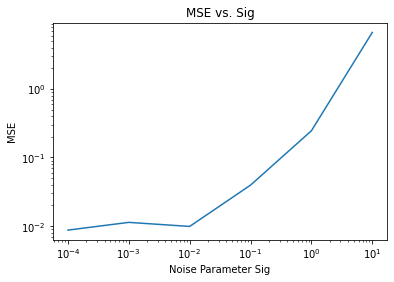

In [25]:
def mse(b, bhat, N = 100, p = 50, sig = 0.1):
    X = np.random.randn(N,p)
    y = np.dot(X, b) + sig * np.random.randn()
    MSE = (1/N) * (la.norm(X @ bhat - y)**2)
    return MSE
    
X, y, b = gen_lstsq(100, 50, sig=0.1)
bhat = np.linalg.lstsq(X, y, rcond=None)[0]
Sigs = [10**k for k in range(-4,2)]
MSEs = []
for n in Sigs:
    MSEs.append(mse(b, bhat, N=100, sig=n))
plt.loglog(Sigs, MSEs)
plt.xlabel('Noise Parameter Sig')
plt.ylabel('MSE')
plt.title('MSE vs. Sig')
plt.show()

### Discussion 1

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations).

In [26]:
X, y, b = gen_lstsq(500, 300, sig=0.1)
from time import time
start = time()
solve_lstsq_qr(X, y)
end = time()
print("Time of computing using solve_lstsq_qr is: " + str(end-start) + " secs.")
start = time()
solve_lstsq_normal(X, y)
end = time()
print("Time of computing using solve_lstsq_normal is: " + str(end-start) + " secs.")

Time of computing using solve_lstsq_qr is: 0.014639139175415039 secs.
Time of computing using solve_lstsq_normal is: 0.0047838687896728516 secs.


---

Discussion: We note that solve_lstsq_normal is faster, since Cholesky has cost of approximately n ** 3 / 3 flops, while QR costs approximately 2 * (n ** 3) / 3 flops.

### Optimization

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [27]:
import scipy.optimize as opt
# Minimization using scipy.optimize.minimize

# Note we define the objective function inside
def solve_lstsq_opt(X, y):
    n = X.shape[0]
    p = X.shape[1]
    def f(b):
        return (1/n) * (la.norm((X @ b - y))**2)
    # Jacobian of function
    def Jf(b):
        return (2/n) * (b.T @ (X.T @ X) - y.T @ X)
    x0 = np.random.rand(p)
    sol = opt.minimize(f, x0, jac=Jf)
    return sol

#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

In [28]:
X, y, b = gen_lstsq(500, 300, sig=0.1)
print(la.norm(solve_lstsq_normal(X, y) - solve_lstsq_opt(X, y).x) < 1e-4)
print(la.norm(solve_lstsq_qr(X, y) - solve_lstsq_opt(X, y).x) < 1e-4)

False
True


### Discussion 2

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [29]:
start = time()
solve_lstsq_opt(X, y)
end = time()
print("Time of computing using solve_lstsq_opt is: " + str(end-start) + " secs.")
solve_lstsq_opt(X, y).nfev

Time of computing using solve_lstsq_opt is: 0.2814328670501709 secs.


69

---

We note that for the method solve_lstsq_opt, the nfev is around 70, which is quite large for our problem. Thus, it is quite predictable that it is slower than the methods using matrix factorizations.

### Scikit Learn

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to solve the linear regression problem. You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `LinearRegression` instead of a `solve_lstsq` function.  Set the keyword `fit_intercept=False`.

[-1.8601089  -1.85539885 -0.31194604  0.68640967 -0.17175061  0.61873587
 -0.68503924  0.08929881  1.10357157 -1.07656978 -0.34687435  1.63843505
 -0.4824415   1.03794982 -0.33929223 -1.23490654 -0.16659202 -0.39746716
 -0.01213744 -0.22525901 -2.43869808 -0.6714586   0.94384879 -0.64368142
  0.55239492 -0.84160427  0.15545793  1.51976533  0.31042539  0.3618946
  1.36277723  0.0627806   1.75878845  2.00952162 -1.01442226 -0.60078533
 -0.43355581 -0.69074045  0.02770965 -0.34118466  2.73411824 -1.36837376
  1.45844886 -0.96230181 -1.83541444  0.47583775  0.03341732  1.24711129
  1.26884769 -0.07441748]


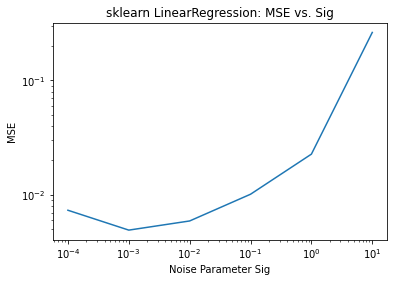

In [11]:
X, y, b = gen_lstsq(100, 50, sig=0.1)
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
print(model.coef_)
model2 = LinearRegression(fit_intercept=False)
model2.fit(X, y)
bhat = model2.coef_
Sigs = [10**k for k in range(-4,2)]
MSEs = []
for n in Sigs:
    MSEs.append(mse(b, bhat, N=100, p=50, sig=n))
plt.loglog(Sigs, MSEs)
plt.xlabel('Noise Parameter Sig')
plt.ylabel('MSE')
plt.title('sklearn LinearRegression: MSE vs. Sig')
plt.show()

## Problem 1 - Ridge Regression (15 points)

We'll now turn to the problem of what to do when `n < p` (there are fewer observations than features).  In this case we can solve $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

The normal equations are singular, and the $R$ term of the QR factorization is not invertible in this case.  We need to do something else.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Optimization

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---

_put the expression for the Jacobian here_

In [12]:
# Answer:
# Let g = lambda * b.T @ b, note that dg/dbi = 2 * lambda * bi
# Then the final expression is (2/n) * (b.T @ (X.T @ X) - y.T @ X) + 2 * lambda * b

### Compute the MSE

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the MSE of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

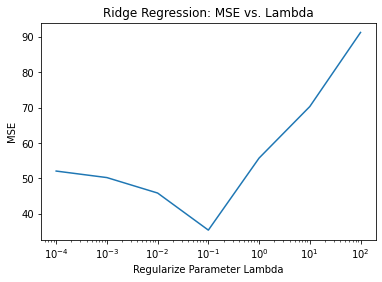

In [13]:
def solve_ridge_opt(X, y, lam=0.1):
    n = X.shape[0]
    p = X.shape[1]
    def f(b):
        return (1/n) * (la.norm((X @ b - y))**2) + lam * (la.norm(b) ** 2)
    # Jacobian of function
    def Jf(b):
        return (2/n) * (b.T @ (X.T @ X) - y.T @ X) + 2 * lam * b
    
    x0 = np.random.rand(p)
    sol = opt.minimize(f, x0, jac=Jf)
    return sol

X, y, b = gen_lstsq(50, 100, sig=0.1)
MSEs = []
lams = [10**k for k in range(-4,3)]
for l in lams:
    bhat = solve_ridge_opt(X, y, lam = l).x
    MSEs.append(mse(b, bhat, N=50, p=100, sig=0.1))
plt.semilogx(lams, MSEs)
plt.xlabel('Regularize Parameter Lambda')
plt.ylabel('MSE')
plt.title('Ridge Regression: MSE vs. Lambda')
plt.show()

### Scikit Learn

Use [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to solve the Ridge regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Ridge` instead of your `solve_ridge_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

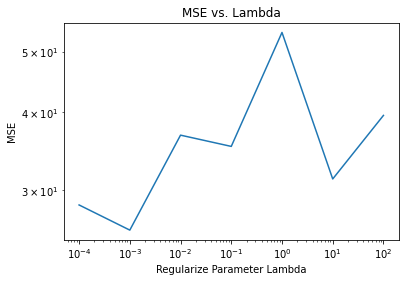

In [14]:
X, y, b = gen_lstsq(50,100, sig=0.1)
from sklearn.linear_model import Ridge
lams = [10**k for k in range(-4,3)]
MSEs = []
for l in lams:
    model3 = Ridge(alpha=l, fit_intercept=False)
    model3.fit(X, y)
    bhat = model3.coef_
    MSEs.append(mse(b, bhat, N=50, p=100, sig=0.1))
plt.loglog(lams, MSEs)
plt.xlabel('Regularize Parameter Lambda')
plt.ylabel('MSE')
plt.title('MSE vs. Lambda')
plt.show()

## Problem 2 - Lasso (15 points)

The Lasso is L1-regularized regression.  This is often used when `p > n`, and when the parameter vector `b` is assumed to be sparse, meaning that it has few non-zero entries.

The minimization problem is
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Where again, $\lambda$ can be chosen.

### Generate Data

We need to modify our generation of data to produce sparse `b`.  Write a function `gen_lstsq_sparse(n, p, sig=0.1, k=10)`, which generates `X` and `y` in the same way as `gen_lstsq`, but now `b` is generated to be a vector of length `p` with `k` random entries set to 1, and all other entries set to 0. Hint: look at `np.random.choice` for generating `k` random integers without replacement.

In [15]:
# Generate X and y in the same way, but generate b in a different way
def gen_lstsq_sparse(n, p, sig=0.1, k=10):
    X = np.random.randn(n,p)
    b = np.zeros(p)
    b_nonzero_pos = np.random.choice(p, k)
    for i in b_nonzero_pos:
        b[i] = 1
    y = np.dot(X, b) + sig * np.random.randn(n)
    return X, y, b

### Optimization

Recall we want to find `bhat` to solve
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_lasso_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_1 = \lambda \sum_i |b_i|
\end{equation}

If $b_i$ is zero, then take $\partial_i |b_i| = 0$ (this is in the [subgradient](https://en.wikipedia.org/wiki/Subderivative)). Hint 2: look at `np.sign` for implementation

---

_put the expression for the Jacobian here_

In [16]:
def solve_lasso_opt(X, y, lam=0.1):
    n = X.shape[0]
    p = X.shape[1]
    def f(b):
        return (1/n) * (la.norm((X @ b - y))**2) + lam * la.norm(b,1)
    # Jacobian of function
    def Jf(b):
        return (2/n) * (b.T @ (X.T @ X) - y.T @ X) + lam * np.sign(b)
    
    x0 = np.random.rand(p)
    sol = opt.minimize(f, x0, jac=Jf)
    return sol

### Compute the MSE

Set `n = 50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  Make a plot that displays the MSE of `bhat` computed using `solve_lasso_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

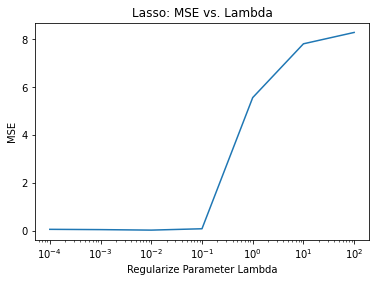

In [17]:
X, y, b = gen_lstsq_sparse(n = 50, p = 100, sig=0.1, k=10)
MSEs = []
lams = [10**k for k in range(-4,3)]
for l in lams:
    bhat = solve_lasso_opt(X, y, lam = l).x
    MSEs.append(mse(b, bhat, N=50, p=100, sig=0.1))
plt.semilogx(lams, MSEs)
plt.xlabel('Regularize Parameter Lambda')
plt.ylabel('MSE')
plt.title('Lasso: MSE vs. Lambda')
plt.show()

### Scikit Learn

Use [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) to solve the Lasso regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Lasso` instead of your `solve_lasso_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

/Users/josh/anaconda3/envs/pycourse/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.060983283933759624, tolerance: 0.04523021242272464
  model = cd_fast.enet_coordinate_descent(


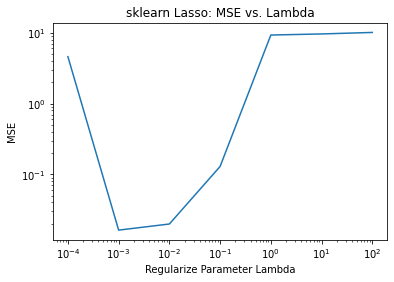

In [18]:
X, y, b = gen_lstsq_sparse(n = 50, p = 100, sig=0.1, k=10)
from sklearn.linear_model import Lasso
lams = [10**k for k in range(-4,3)]
MSEs = []
for l in lams:
    model4 = Lasso(alpha=l, fit_intercept=False)
    model4.fit(X, y)
    bhat = model4.coef_
    MSEs.append(mse(b, bhat, N=50, p=100, sig=0.1))
plt.loglog(lams, MSEs)
plt.xlabel('Regularize Parameter Lambda')
plt.ylabel('MSE')
plt.title('sklearn Lasso: MSE vs. Lambda')
plt.show()

## Problem 3 - Elastic Net (20 points)

Another option when `p > n` is the [Elastic Net]() which combines L1 and L2 regularization.

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda_1 \|b\|_1 + \lambda_2 \|b\|_2^2
\end{equation}
Where we get to choose $\lambda_1$ and $\lambda_2$.

You can find a function that does this in [`sklearn.linear_model.ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

In this problem, you'll write a class that emulates the behavior of a Scikit learn class. Use `scipy.optimize.minimize` to solve the optimization problem.


### Jacobian

Give an expression for the Jacobian for the optimization objective function.  You've already done all the hard work for this in problems 1 and 2

---

_put the Jacobian expression here_

### Write the Class

Define a Python Class `ElasticNet`.  When you initialize the class you should be able to provide keyword arguments `lam1` for $\lambda_1$ and `lam2` for $\lambda_2$.  Give each these keyword arguments a default value of `0.5`.

In addition to `__init__`, your class should provide two methods:
1. `fit(X, y)` - sets an attribute `bhat` which solves the optimization problem (use the parameters `lam1` and `lam2` provided in initialization).  Use `scipy.optimize.minimize`
2. `predict(X)` - predict values of `y` as `X @ bhat`

In [19]:
class ElasticNet(object):
    def __init__(self, lam1 = 0.5, lam2 = 0.5):
        self.lam1 = lam1
        self.lam2 = lam2
    def fit(self, X, y):
        self.X = X
        n = self.X.shape[0]
        p = self.X.shape[1]
        x0 = np.random.rand(p)
        f = lambda b: (1/n) * (la.norm((X @ b - y))**2) + self.lam1 * la.norm(b,1) + self.lam2 * (la.norm(b) ** 2)
        self.bhat = opt.minimize(f, x0).x
    def predict(X):
        self.y = X @ self.bhat

### Compute the MSE

Set `n=50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  

Set `n=50`, `p=100`, and `sig=0.1` to generate a problem using `gen_lstsq`.

Make a plot that displays the MSE of the model computed using your `ElasticNet` class using `lam1=lam2` varying between `1e-4` and `1e2` for each of the generated problems (your plot should have 2 lines).  Give your plot a title, axis labels, and a legend.

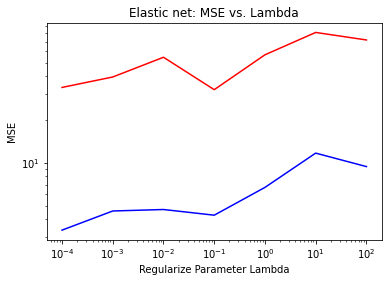

In [20]:
# Generate problem 1
X, y, b = gen_lstsq_sparse(n = 50, p = 100, sig=0.1, k=10)
lams = [10**k for k in range(-4,3)]
MSEs_1 = []
MSEs_2 = []
for l in lams:
    model_1 = ElasticNet(lam1 = l, lam2 = l)
    model_1.fit(X, y)
    bhat = model_1.bhat
    MSEs_1.append(mse(b, bhat, N=50, p=100, sig=0.1))
plt.loglog(lams, MSEs_1, c = 'b')
X, y, b = gen_lstsq(n = 50, p = 100, sig=0.1)
for l in lams:
    model_2 = ElasticNet(lam1 = l, lam2 = l)
    model_2.fit(X, y)
    bhat = model_2.bhat
    MSEs_2.append(mse(b, bhat, N=50, p=100, sig=0.1))
plt.loglog(lams, MSEs_2, c = 'r')
plt.xlabel('Regularize Parameter Lambda')
plt.ylabel('MSE')
plt.title('Elastic net: MSE vs. Lambda')
plt.show()

## Problem 4 - Real Data (20 points)

In this problem you'll use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/).  We'll focus on the red wines found in [`winequality-red.csv`](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv).  The goal is to train a machine learning model that will predict the wine quality from a variety of other features.

### Load the data set

Load the wines in `windquality-red.csv` into a Pandas data frame. Note that this file has column labels, which are interpreted in the data set documentation:

Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

Note that this file uses semi-colons `;` to delimit values.  You can use `delimiter=';'` as a keyword argument.

In [21]:
# Here we load the data into a Pandas data frame
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', 
                 delimiter = ';', names = ['fixed acidity', 'volatile acidity', 'citric acid','residual sugar', 
                                           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                                           'pH', 'sulphates', 'alcohol', 'quality'])
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6
5,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1595,6.2,0.6,0.08,2,0.09,32,44,0.9949,3.45,0.58,10.5,5
1596,5.9,0.55,0.1,2.2,0.062,39,51,0.99512,3.52,0.76,11.2,6
1597,6.3,0.51,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11,6
1598,5.9,0.645,0.12,2,0.075,32,44,0.99547,3.57,0.71,10.2,5


The first 11 columns will be features for the model (used in the design matrix `X`), and the last column (quality) is the quantity we're tyring to predict (the response `y`).

### Split the Data in to Training and Testing Sets

Split the data `X, y` into `X_train, y_train, X_test, y_test` using `sklearn`.  Use 70% of the data for training, and 30% of the data for testing.


In [22]:
from sklearn.model_selection import train_test_split
X = df[['fixed acidity', 'volatile acidity', 'citric acid','residual sugar', 
                                           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                                           'pH', 'sulphates', 'alcohol']].to_numpy()
X = X.astype(np.float)
y = df['quality'].to_numpy()
y = y.astype(np.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1119, 11) (1119,)
(480, 11) (480,)


### Train a Model and Measure Error

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to fit a linear regression model to your training data.

Use [`sklearn.metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) to compute the MSE on your test set.

In [23]:
from sklearn.metrics import mean_squared_error
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
MSE = mean_squared_error(y_test, model.predict(X_test))
print("MSE for the test set is: " + str(MSE))

MSE for the test set is: 0.4007803663750104


### Try Some Different Models

Note: you don't need to know anything about these models.  You can just use the `fit` and `predict` methods, and the default parameters.

Use the following `sklearn` classes to fit models and make predictions:
* [`sklearn.ensemble.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
* [`sklearn.neural_network.MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)
* [`sklearn.neighbors.KNeighborsRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)

Which model gives the best MSE on the test data?

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
model1 = RandomForestRegressor()
model1.fit(X_train, y_train)
MSE1 = mean_squared_error(y_test, model1.predict(X_test))
print("MSE for Random Forest Model: " + str(MSE1))
model2 = MLPRegressor()
model2.fit(X_train, y_train)
MSE2 = mean_squared_error(y_test, model2.predict(X_test))
print("MSE for MLP Regressor: " + str(MSE2))
model3 = KNeighborsRegressor()
model3.fit(X_train, y_train)
MSE3 = mean_squared_error(y_test, model3.predict(X_test))
print("MSE for KNeighbors Regressor: " + str(MSE3))

MSE for Random Forest Model: 0.3496810416666667
MSE for MLP Regressor: 0.47982382268988766
MSE for KNeighbors Regressor: 0.5365
